# Credit Risk Analysis: Loan Default Prediction
## NB07 — Weight of Evidence (WoE) / Information Value (IV) Exploration

### Two Worlds of Credit Risk — Why This Notebook Exists

The credit risk industry has two parallel traditions, and a complete analyst knows both.

**The machine learning world** — where our project has lived so far — uses algorithms like XGBoost that learn complex, non-linear patterns from thousands of data points simultaneously. These models perform well but act as "black boxes": a loan officer cannot easily explain *why* the algorithm flagged a borrower. We addressed this in NB06 with SHAP.

**The traditional scorecard world** — still dominant at banks, credit bureaus, and any institution under regulatory scrutiny — uses transparent, points-based systems. A loan officer literally adds up points assigned to each characteristic: "Applicant's income is $60k–$100k: +8 points. DTI is 20–30%: +5 points. Grade is B: +12 points." The total score maps directly to an approve/decline decision. There is no algorithm to interrogate — the logic lives in a table anyone can read.

The mathematical foundation of traditional scorecards is **WoE (Weight of Evidence) binning** paired with **IV (Information Value)**. This approach was standard practice at credit bureaus (Experian, Equifax, TransUnion) and banks long before machine learning entered the picture — and it remains heavily used today at institutions with legacy infrastructure or regulatory reporting requirements.

**Why study WoE/IV even though we have XGBoost?**
1. It provides a completely model-free, standalone view of which features carry predictive signal — useful for validating our SHAP findings
2. It demonstrates that you can operate in both worlds (a meaningful differentiator in job interviews at traditional institutions)
3. The resulting scorecard prototype shows the interpretability–performance trade-off concretely, which is useful context for NB08


---
## Concept Introduction: WoE and IV from First Principles

*This section is entirely new material. We'll build up from scratch with a concrete worked example before writing any code.*

---

### Step 1 — What is "binning" and why do we need it?

A continuous feature like annual income can take thousands of unique values. To analyze its relationship to default risk in a structured way, we first divide it into discrete **bins** — ordered ranges of values. Think of a loan officer sorting applications into piles:

- **Pile 1:** Annual income under \$30,000
- **Pile 2:** Annual income \$30,000 – \$60,000
- **Pile 3:** Annual income \$60,000 – \$100,000
- **Pile 4:** Annual income over \$100,000

Each pile is a bin. Once we have bins, we can ask a simple question for each one: **"What fraction of the borrowers in this pile defaulted?"** This gives us the default rate by income level.

**How do we choose where to draw the lines?** We use **optimal binning** — a decision-tree-like algorithm that places the bin boundaries exactly where the default rate changes most sharply. This is more useful than equal-width bins (which divide the range into equal segments regardless of risk) or equal-frequency bins (which put the same number of borrowers in each bin regardless of their risk profile).

---

### Step 2 — Computing WoE for each bin

Once we have bins and their default rates, WoE answers: **"Relative to the overall dataset, does this bin contain an unusually high or unusually low share of defaulters?"**

The formula is:

$$\text{WoE}_i = \ln\left(\frac{\text{\% of all non-defaults falling in bin } i}{\text{\% of all defaults falling in bin } i}\right)$$

Let's work through a concrete example. Say we have **1,000 borrowers: 200 defaults, 800 non-defaults** (20% default rate). Here's the income breakdown:

| Bin | Borrowers | Defaults | Non-defaults | % of all 200 defaults | % of all 800 non-defaults | WoE |
|-----|-----------|----------|--------------|----------------------|--------------------------|-----|
| Income < \$30k | 100 | 35 | 65 | 35/200 = **17.5%** | 65/800 = **8.1%** | ln(8.1/17.5) = **−0.77** |
| Income \$30k–\$60k | 350 | 80 | 270 | 80/200 = **40.0%** | 270/800 = **33.8%** | ln(33.8/40.0) = **−0.17** |
| Income \$60k–\$100k | 350 | 60 | 290 | 60/200 = **30.0%** | 290/800 = **36.3%** | ln(36.3/30.0) = **+0.19** |
| Income > \$100k | 200 | 25 | 175 | 25/200 = **12.5%** | 175/800 = **21.9%** | ln(21.9/12.5) = **+0.56** |

**Reading WoE values:**
- **Negative WoE** = this bin is over-represented in defaults → **risky bin**. The "income < $30k" bin contributes 17.5% of all defaults but only 8.1% of non-defaults — it punches above its weight in defaults.
- **Positive WoE** = this bin is under-represented in defaults → **safe bin**. The "> $100k" bin contributes only 12.5% of defaults but 21.9% of non-defaults — high earners default less than average.
- **WoE ≈ 0** = this bin's default rate is roughly average — neither risky nor protective.

The natural log (ln) makes the scale symmetric and interpretable: WoE of +0.5 means the bin is about as "good" as WoE of −0.5 is "bad."

---

### Step 3 — Computing IV for the whole feature

**Information Value (IV)** combines the WoE values across all bins into a single number that measures how predictive the entire feature is:

$$\text{IV} = \sum_{\text{all bins}} \left(\text{\% non-defaults in bin} - \text{\% defaults in bin}\right) \times \text{WoE of bin}$$

Using our example:
- Income < \$30k: (8.1% − 17.5%) × (−0.77) = **+0.072**
- Income \$30k–\$60k: (33.8% − 40.0%) × (−0.17) = **+0.011**
- Income \$60k–\$100k: (36.3% − 30.0%) × (+0.19) = **+0.012**
- Income > \$100k: (21.9% − 12.5%) × (+0.56) = **+0.053**

**Total IV = 0.072 + 0.011 + 0.012 + 0.053 = 0.148**

Notice: IV contributions are **always positive** — a strongly risky bin and a strongly safe bin both contribute positively, because IV measures the *magnitude of separation* regardless of direction.

---

### Step 4 — The IV interpretation scale

This scale was established by credit risk practitioners through decades of scorecard development across thousands of portfolios:

| IV Range | Predictive Power | What it means in practice |
|----------|-----------------|--------------------------|
| < 0.02 | **Useless** | Feature separates defaults barely better than random — exclude it |
| 0.02 – 0.10 | **Weak** | Some signal, probably not worth a standalone feature |
| 0.10 – 0.30 | **Medium** | Solid predictor — definitely include |
| 0.30 – 0.50 | **Strong** | High-value feature — a core pillar of the model |
| > 0.50 | **Suspicious** | Check for data leakage or look-ahead bias — legitimate features almost never hit this |

**Important nuance:** IV and correlation measure different things. IV captures non-linear relationships and threshold effects that Pearson correlation misses. A feature with IV=0.25 might have a Pearson correlation of only 0.15 — because the risk is concentrated in a specific bin rather than spread linearly.

---

### Step 5 — How WoE transformation enables a transparent scorecard

Here's the key insight: once we compute WoE for each bin of each feature, we can **replace the raw feature value with its WoE value** before fitting a logistic regression.

Why is this useful? Logistic regression assumes a *linear* relationship between each feature and the log-odds of default. But in real lending data, the relationship is non-linear: risk is flat for low DTI values, then jumps sharply above 35%. Standard logistic regression can't capture this without polynomial terms.

**WoE transformation solves this by pre-encoding the non-linearity.** After replacement, each feature value is already the WoE of its bin — and WoE by construction represents the feature's *risk contribution* on the log-odds scale. The logistic regression then fits a simple linear model through these pre-processed values, and the result is both interpretable and aligned with the risk structure.

The final scorecard translates LR coefficients × WoE values into points — giving underwriters a literal point-addition table they can use by hand.


In [1]:
# ── Portable root detection ───────────────────────────────────────────────────
from pathlib import Path
import os

root = Path.cwd()
while not (root / '.git').exists() and root != root.parent:
    root = root.parent
os.chdir(root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid', palette='muted')

# ── Install / import optbinning ───────────────────────────────────────────────
import subprocess, sys
try:
    from optbinning import OptimalBinning
    print("optbinning available")
except ImportError:
    print("Installing optbinning...")
    subprocess.run([sys.executable, '-m', 'pip', 'install', '--quiet', 'optbinning'], check=True)
    from optbinning import OptimalBinning
    print("optbinning installed")

# ── Load train / test splits ──────────────────────────────────────────────────
train_df = pd.read_parquet('data/splits/train.parquet')
test_df  = pd.read_parquet('data/splits/test.parquet')

X_train = train_df.drop(columns='target')
y_train = train_df['target']
X_test  = test_df.drop(columns='target')
y_test  = test_df['target']

print(f"Train: {X_train.shape[0]:,} rows × {X_train.shape[1]} features  "
      f"(default rate: {y_train.mean()*100:.2f}%)")
print(f"Test:  {X_test.shape[0]:,} rows × {X_test.shape[1]} features  "
      f"(default rate: {y_test.mean()*100:.2f}%)")

# ── Load SHAP importance from NB06 outputs ────────────────────────────────────
# We saved shap_values.npy and feature_names.csv in NB06 for exactly this reuse.
shap_values   = np.load('outputs/shap_plots/shap_values.npy')
feature_names = pd.read_csv('outputs/shap_plots/feature_names.csv', header=None)[0].tolist()

mean_abs_shap = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=feature_names
).sort_values(ascending=False)

# Top 10 features by SHAP importance — these are what we'll analyse with WoE/IV
top10 = mean_abs_shap.head(10).index.tolist()
shap_rank = {feat: r+1 for r, feat in enumerate(mean_abs_shap.index)}

print(f"\nTop 10 SHAP features (from NB06):")
for feat in top10:
    print(f"  {shap_rank[feat]:2d}. {feat:<35}  mean|SHAP|={mean_abs_shap[feat]:.4f}")


optbinning available
Train: 216,709 rows × 53 features  (default rate: 22.58%)
Test:  54,178 rows × 53 features  (default rate: 22.58%)

Top 10 SHAP features (from NB06):
   1. sub_grade_numeric                    mean|SHAP|=0.4089
   2. dti_x_loan_to_income                 mean|SHAP|=0.1472
   3. long_term_loan                       mean|SHAP|=0.1220
   4. annual_inc                           mean|SHAP|=0.0792
   5. tot_cur_bal                          mean|SHAP|=0.0787
   6. open_acc                             mean|SHAP|=0.0616
   7. total_acc                            mean|SHAP|=0.0584
   8. loan_to_income_ratio                 mean|SHAP|=0.0581
   9. total_rev_hi_lim                     mean|SHAP|=0.0576
  10. dti                                  mean|SHAP|=0.0474


---
## What Are These 10 Features? Plain-Language Definitions

Before running the WoE analysis, here's a precise description of each of the top 10 SHAP features in plain lending terms. Understanding *what* each feature measures is essential for interpreting whether the WoE bin patterns make business sense.

| # | Feature | What it measures | Type |
|---|---------|-----------------|------|
| 1 | `sub_grade_numeric` | Lending Club's own internal risk rating converted to a number. Grades run A1 (=1) through G5 (=35), where 1 is the safest and 35 is the riskiest. This is the platform's credit assessment — similar to an internal credit score. | Discrete integer 1–35 |
| 2 | `dti_x_loan_to_income` | An **engineered interaction feature** (created in NB03): the product of DTI × loan-to-income ratio. A borrower who is *both* heavily leveraged overall (high DTI) *and* taking a large loan relative to income scores high on both dimensions simultaneously — this feature captures compound debt stress. | Continuous float |
| 3 | `long_term_loan` | A **binary flag** (1 = 60-month loan, 0 = 36-month loan). 60-month loans give more time for life circumstances (job loss, illness, divorce) to disrupt repayment. In our data, 60-month loans default at roughly 35% vs. 19% for 36-month loans. | Binary 0/1 |
| 4 | `annual_inc` | The borrower's self-reported annual income, capped at the 99th percentile ($240k in NB02) to remove extreme outliers. Higher income provides a larger buffer against repayment shocks. | Continuous float |
| 5 | `tot_cur_bal` | Total current outstanding balance across *all* the borrower's open accounts (credit cards, mortgages, auto loans, other installment loans). Measures how much total debt the borrower is currently carrying. | Continuous float |
| 6 | `open_acc` | Number of credit accounts currently open — active credit cards, lines of credit, loans, etc. More open accounts can mean better credit diversity or can mean the borrower is actively drawing credit from multiple sources. | Integer count |
| 7 | `total_acc` | Total number of credit accounts ever opened in the borrower's history (including closed accounts). A proxy for credit history breadth and experience. | Integer count |
| 8 | `loan_to_income_ratio` | **Engineered in NB03:** loan amount divided by annual income. A ratio of 0.40 means the loan equals 40% of the borrower's annual income — a significant financial commitment. The threshold of ~0.40 was noted in NB06 as a meaningful risk inflection point. | Continuous float (0 to ~2) |
| 9 | `total_rev_hi_lim` | Total revolving credit limit across all revolving accounts (credit cards, HELOCs). A very high limit combined with high utilization is particularly risky; a high limit with low utilization often signals a creditworthy borrower. | Continuous float |
| 10 | `dti` | **Debt-to-income ratio:** total monthly debt payments (excluding mortgage in many definitions) divided by monthly gross income, expressed as a percentage. A DTI of 25% means 25 cents of every dollar earned goes toward debt service. The standard "danger zone" in lending is generally DTI > 36–43%. | Continuous float |

*Note: features 1, 3, 8, and the interaction in feature 2 were either engineered in NB03 or numerically encoded — they don't appear in the raw dataset exactly as named. This is worth calling out in any portfolio walkthrough.*


Fitting OptimalBinning for top 10 features...



  sub_grade_numeric                    IV=0.4142  (8 bins)


  dti_x_loan_to_income                 IV=0.1921  (8 bins)
  long_term_loan                       IV=0.1518  (2 bins)


  annual_inc                           IV=0.0451  (8 bins)


  tot_cur_bal                          IV=0.0496  (4 bins)
  open_acc                             IV=0.0037  (8 bins)


  total_acc                            IV=0.0047  (8 bins)


  loan_to_income_ratio                 IV=0.1528  (8 bins)


  total_rev_hi_lim                     IV=0.0352  (7 bins)


  dti                                  IV=0.1040  (8 bins)


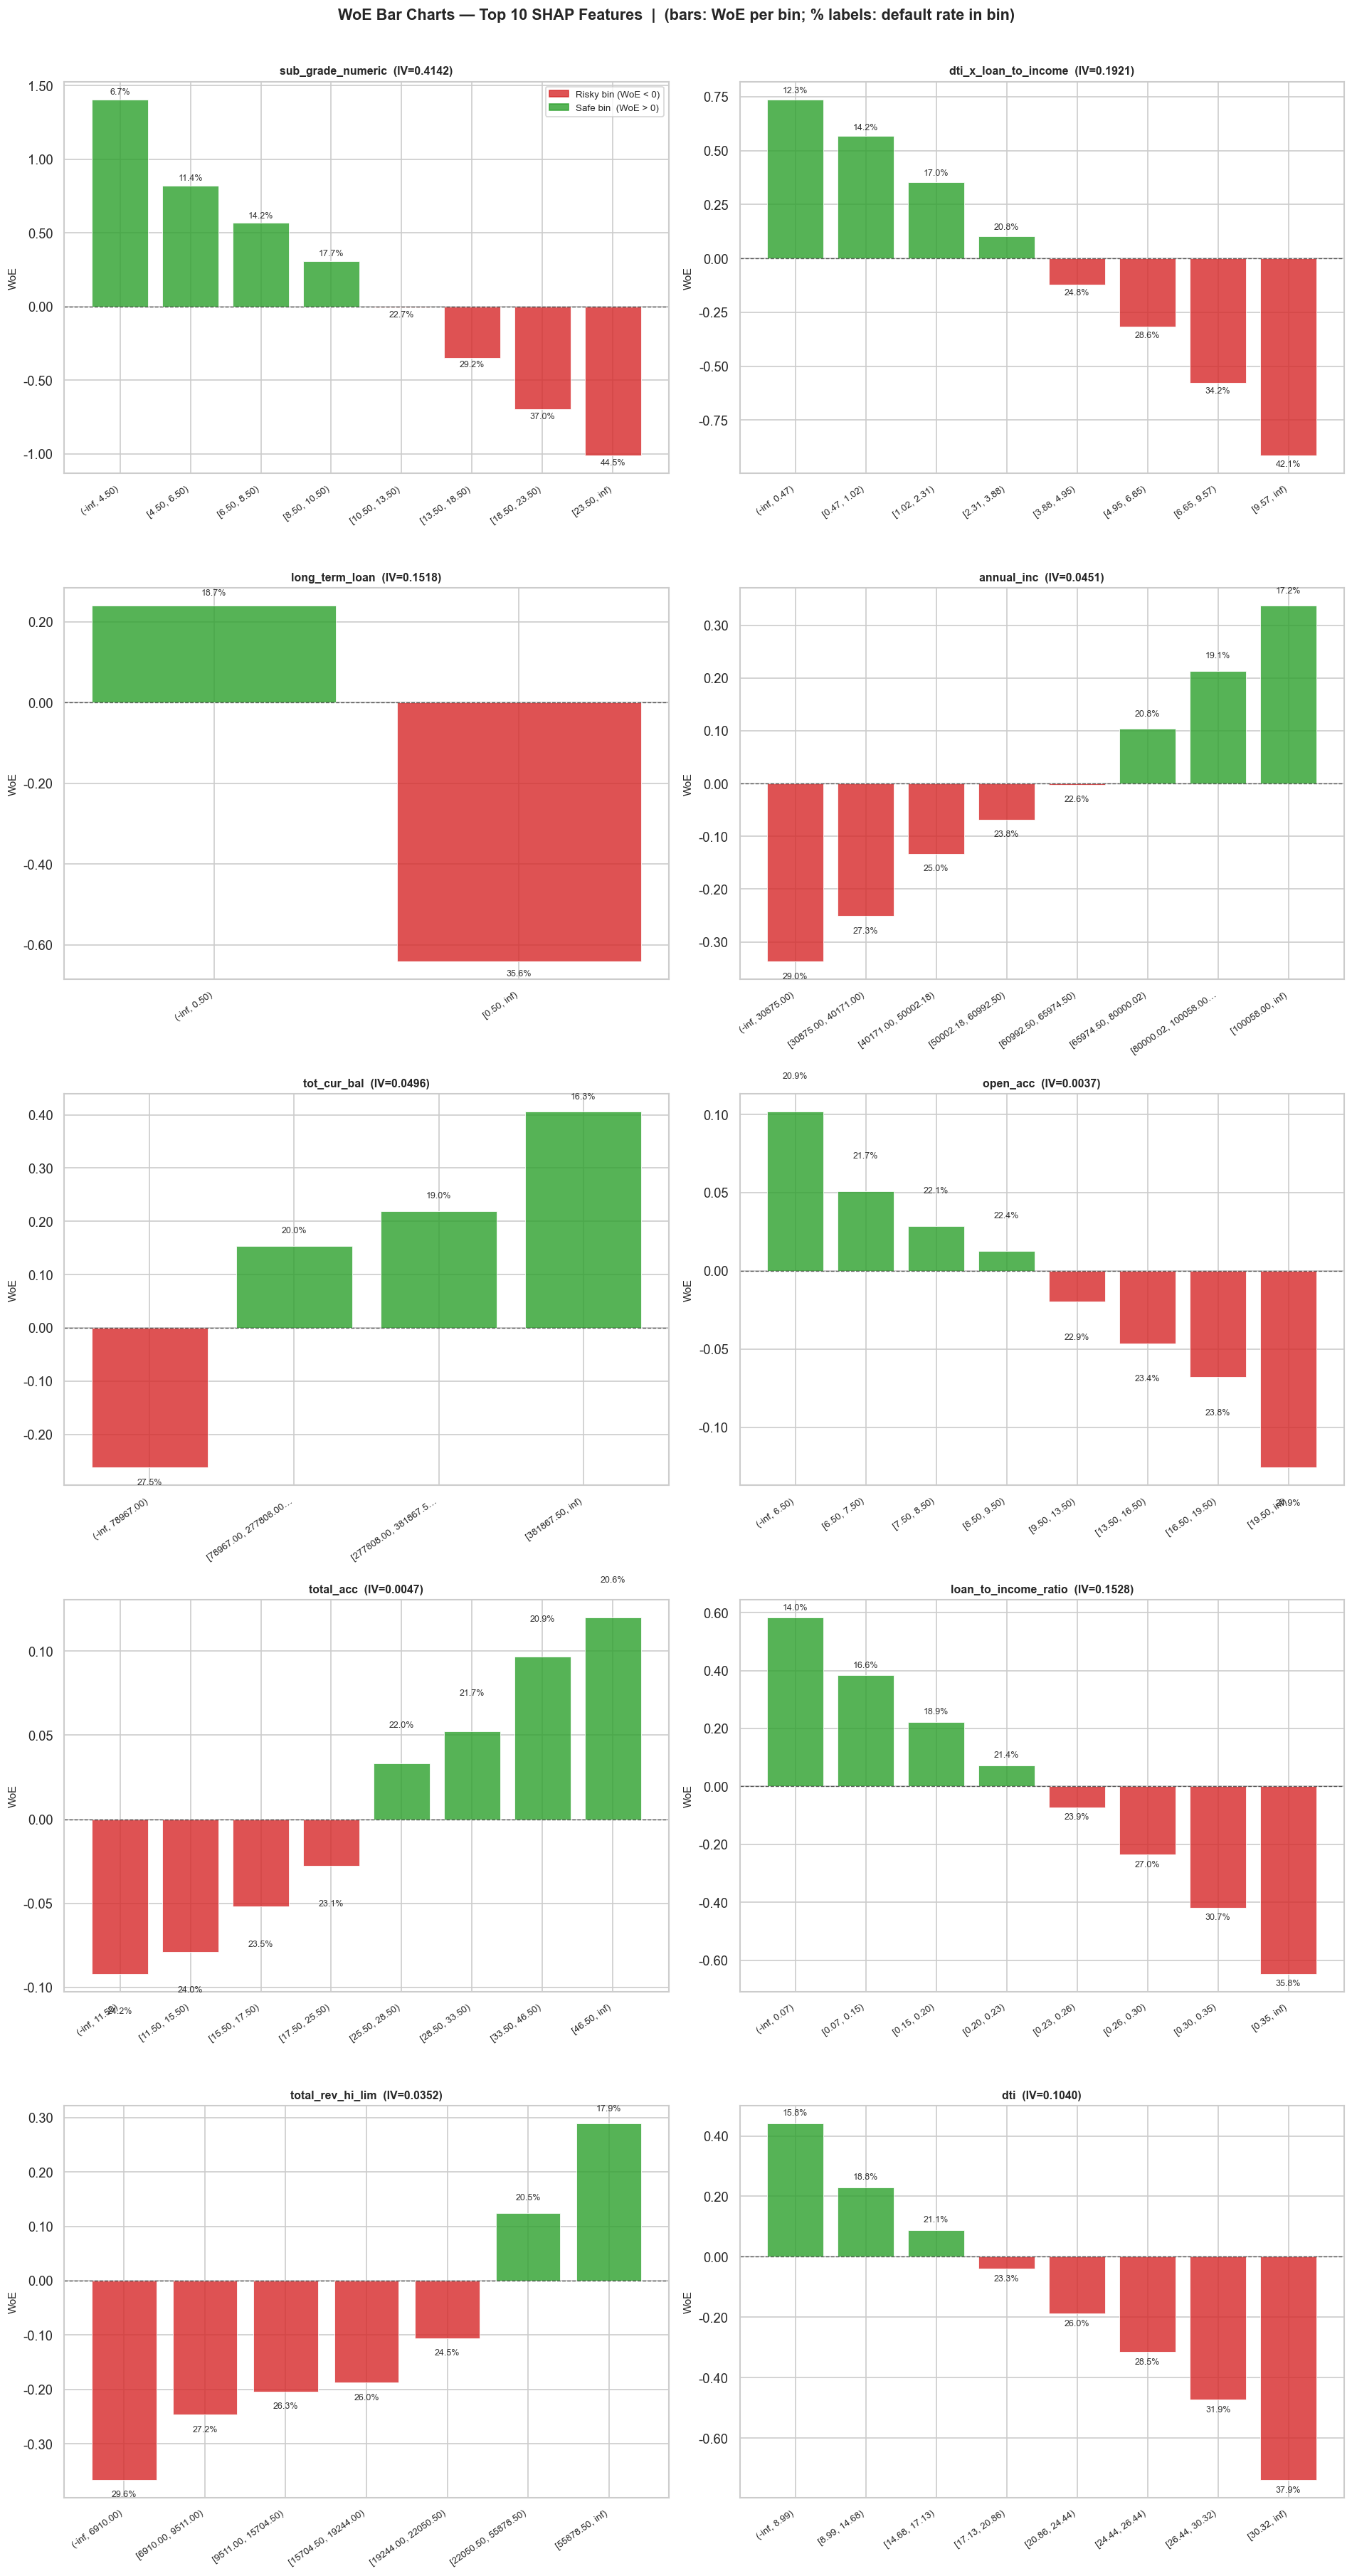

Saved: outputs/woe_plots/woe_bar_charts.png


In [2]:
# ── WoE binning: fit OptimalBinning for each top-10 feature ──────────────────
# OptimalBinning uses a monotone-constrained decision tree to find the cutpoints
# that best separate defaults from non-defaults while enforcing WoE monotonicity.
# Monotonicity means WoE values move in one direction as the feature increases —
# this is an important constraint for scorecards (makes results explainable).

os.makedirs('outputs/woe_plots', exist_ok=True)

bin_results = {}   # stores {'iv': float, 'table': DataFrame, 'ob': OptimalBinning}

print("Fitting OptimalBinning for top 10 features...\n")
for feat in top10:
    x = X_train[feat].values.astype(float)
    y = y_train.values

    # Binary features get max 2 bins; continuous get up to 8
    n_unique = X_train[feat].nunique()
    max_bins = 2 if n_unique <= 2 else 8

    ob = OptimalBinning(
        name=feat,
        dtype='numerical',
        max_n_bins=max_bins,
        monotonic_trend='auto_asc_desc',   # allow ascending or descending WoE monotone
    )
    ob.fit(x, y)

    bt    = ob.binning_table
    df_bt = bt.build()

    # Filter to actual data bins — exclude Special, Missing, and Totals rows
    df_bins = df_bt[
        ~df_bt['Bin'].isin(['Special', 'Missing']) & (df_bt.index != 'Totals')
    ].copy()

    iv = bt.iv
    bin_results[feat] = {'iv': iv, 'table': df_bins, 'ob': ob}

    print(f"  {feat:<35}  IV={iv:.4f}  ({len(df_bins)} bins)")

# ── WoE bar chart grid: one subplot per feature ───────────────────────────────
fig, axes = plt.subplots(5, 2, figsize=(16, 30))
axes_flat = axes.flatten()

for i, feat in enumerate(top10):
    ax     = axes_flat[i]
    df_b   = bin_results[feat]['table']
    woe    = df_b['WoE'].values
    labels = df_b['Bin'].astype(str).values
    iv     = bin_results[feat]['iv']
    ev_rt  = df_b['Event rate'].values

    # Shorten long bin labels for readability
    short_labels = [lb[:20] + ('…' if len(lb) > 20 else '') for lb in labels]

    colors = ['#d62728' if w < 0 else '#2ca02c' for w in woe]   # red=risky, green=safe
    x_pos  = np.arange(len(woe))

    bars = ax.bar(x_pos, woe, color=colors, alpha=0.8, edgecolor='white', linewidth=0.6)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.6)

    # Annotate each bar with the event rate
    for j, (b, w, er) in enumerate(zip(bars, woe, ev_rt)):
        va   = 'bottom' if w >= 0 else 'top'
        offs = 0.02 if w >= 0 else -0.02
        ax.text(j, w + offs, f'{er*100:.1f}%', ha='center', va=va, fontsize=7.5, color='#333333')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(short_labels, rotation=35, ha='right', fontsize=8)
    ax.set_title(f'{feat}  (IV={iv:.4f})', fontsize=9.5, fontweight='bold')
    ax.set_ylabel('WoE', fontsize=9)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

    # Legend for first subplot only
    if i == 0:
        ax.legend(handles=[
            mpatches.Patch(color='#d62728', alpha=0.8, label='Risky bin (WoE < 0)'),
            mpatches.Patch(color='#2ca02c', alpha=0.8, label='Safe bin  (WoE > 0)'),
        ], fontsize=8, loc='upper right')

plt.suptitle('WoE Bar Charts — Top 10 SHAP Features  |  (bars: WoE per bin; % labels: default rate in bin)',
             fontsize=13, fontweight='bold', y=1.005)
plt.tight_layout()
plt.savefig('outputs/woe_plots/woe_bar_charts.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/woe_plots/woe_bar_charts.png")


### Reading the WoE Charts — What the Bin Patterns Tell Us

Each chart shows how default risk varies across the range of one feature. **Red bars** (WoE < 0) are risky bins — that range of values is over-represented in defaults. **Green bars** (WoE > 0) are safe bins. The percentage labels show the actual default rate within each bin.

**Feature-by-feature interpretation:**

**`sub_grade_numeric` (grades 1–35):** Expect a strongly descending WoE pattern — early grades (A-tier, low numbers) should have high positive WoE (safe), with WoE turning sharply negative in the D/E/F/G tiers (high numbers). The steepness and shape of this descent tells us how "granular" Lending Club's risk tiers are. If the WoE chart is nearly linear, the platform's grading is well-calibrated. If it's stepwise, certain grade boundaries carry disproportionate risk jumps.

**`dti_x_loan_to_income` (engineered interaction):** This is the compound stress feature. Expect low/zero values (both ratios small) to be safe bins, with WoE falling sharply as the interaction grows. Because it's a product of two risk factors, the scale is nonlinear — the highest values represent borrowers who are simultaneously over-leveraged on both dimensions.

**`long_term_loan` (binary):** Only two bins — this chart will show two bars: WoE for 60-month loans and WoE for 36-month loans. The 60-month bar should be strongly negative (risky) and the 36-month bar positive (safe). The gap between them quantifies how much the loan term matters after controlling for all other factors (in standalone IV terms — not controlling for other features, which is what SHAP does).

**`annual_inc`:** Expect a monotone ascending pattern — lower income bins are risky (negative WoE), higher income bins are safe (positive WoE). Look for whether there's a *kink* around the median income ($50k–$60k) where the risk relationship steepens. This kink, if present, represents a useful underwriting threshold.

**`tot_cur_bal` (total current balance):** The relationship here can be non-obvious. Very high total balances might indicate financially successful borrowers (mortgages, business loans), or they might indicate over-extension. Watch for a U-shaped or non-monotone pattern — if the most risky bin is in the middle rather than the extremes, this feature has complex risk behavior that WoE captures but linear correlation would miss.

**`dti` (debt-to-income ratio):** Should show a clean ascending risk pattern — lower DTI is safe (positive WoE), higher DTI is risky (negative WoE). The inflection point around DTI=25–35% is the traditional industry "yellow zone" — check whether our data confirms this threshold.

**Key takeaway from the charts:** Any feature where the WoE pattern is **monotone** (steadily increasing or decreasing) is a clean, well-behaved risk signal that works well in a scorecard. Features with non-monotone WoE (risk goes up, then down, then up) are harder to use in scorecards but may still be valuable in tree-based models — this is one reason why XGBoost can capture signals that scorecards struggle with.


Feature                                  IV  Power         IV Rank  SHAP Rank   Shift
  sub_grade_numeric                  0.4142  Strong              1          1       0
  dti_x_loan_to_income               0.1921  Medium              2          2       0
  loan_to_income_ratio               0.1528  Medium              3          8      +5
  long_term_loan                     0.1518  Medium              4          3      -1
  dti                                0.1040  Medium              5         10      +5
  tot_cur_bal                        0.0496  Weak                6          5      -1
  annual_inc                         0.0451  Weak                7          4      -3
  total_rev_hi_lim                   0.0352  Weak                8          9      +1
  total_acc                          0.0047  Useless             9          7      -2
  open_acc                           0.0037  Useless            10          6      -4


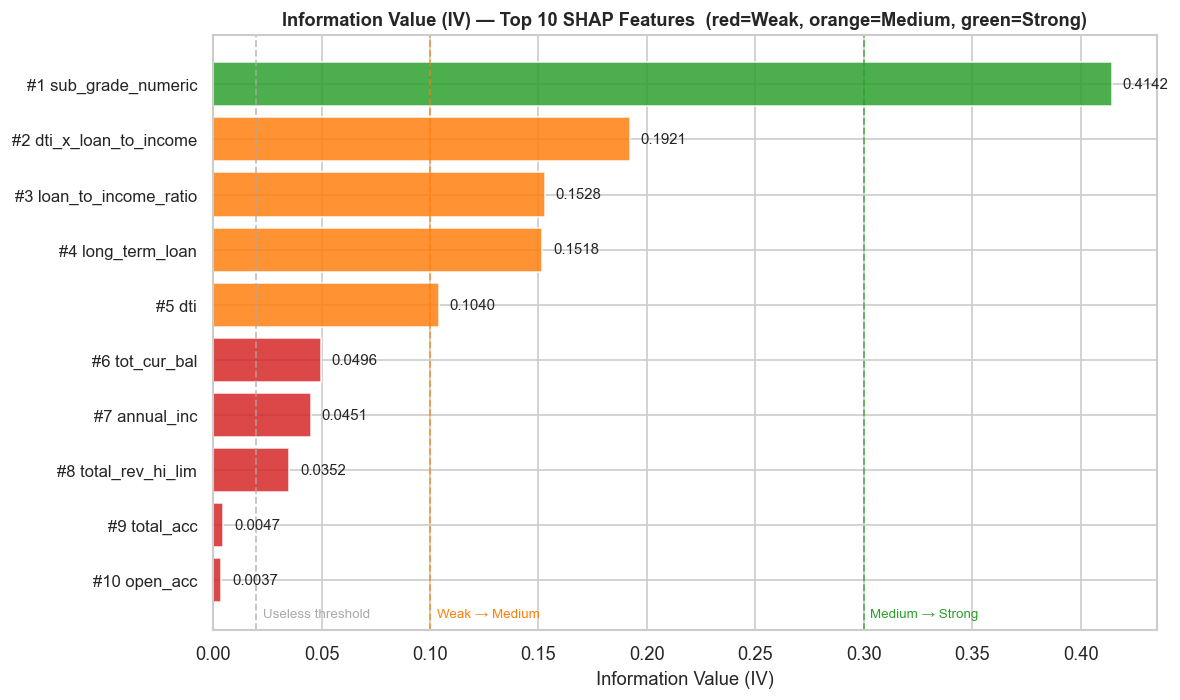

Saved: outputs/woe_plots/iv_ranking.png


In [3]:
# ── IV ranking table with SHAP comparison ────────────────────────────────────
# We compare IV (standalone predictive power) against SHAP rank (importance
# within the context of all other features in the XGBoost model).
# Divergences reveal features that are redundant vs. independently powerful.

iv_scale = lambda iv: (
    'Useless'      if iv < 0.02  else
    'Weak'         if iv < 0.10  else
    'Medium'       if iv < 0.30  else
    'Strong'       if iv < 0.50  else
    'Suspicious'
)

rows = []
for feat in top10:
    iv   = bin_results[feat]['iv']
    rows.append({
        'Feature':         feat,
        'IV':              round(iv, 4),
        'Predictive Power': iv_scale(iv),
        'IV Rank':         0,         # filled below
        'SHAP Rank (NB06)': shap_rank[feat],
        'Mean |SHAP|':     round(mean_abs_shap[feat], 4),
    })

df_iv = pd.DataFrame(rows).sort_values('IV', ascending=False).reset_index(drop=True)
df_iv['IV Rank'] = df_iv.index + 1

# Rank shift: positive = IV rank is higher (better) than SHAP rank
df_iv['Rank Shift'] = df_iv['SHAP Rank (NB06)'] - df_iv['IV Rank']
df_iv['Direction']  = df_iv['Rank Shift'].apply(
    lambda d: '↑ higher by IV' if d > 0 else ('↓ lower by IV' if d < 0 else '= same')
)

print("=" * 90)
print(f"{'Feature':<35}  {'IV':>6}  {'Power':<12}  {'IV Rank':>7}  {'SHAP Rank':>9}  {'Shift':>6}")
print("=" * 90)
for _, row in df_iv.iterrows():
    shift_str = f"+{row['Rank Shift']}" if row['Rank Shift'] > 0 else str(row['Rank Shift'])
    print(f"  {row['Feature']:<33}  {row['IV']:>6.4f}  {row['Predictive Power']:<12}  "
          f"{row['IV Rank']:>7}  {row['SHAP Rank (NB06)']:>9}  {shift_str:>6}")
print("=" * 90)

# ── Visualise: IV bar chart with strength bands ───────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
colors_iv = ['#d62728' if iv < 0.10 else '#ff7f0e' if iv < 0.30 else '#2ca02c'
             for iv in df_iv['IV']]

bars = ax.barh(range(len(df_iv)), df_iv['IV'], color=colors_iv, alpha=0.85, edgecolor='white')

# Threshold reference lines
for thresh, label, col in [(0.02, 'Useless threshold', '#aaaaaa'),
                            (0.10, 'Weak → Medium',    '#ff7f0e'),
                            (0.30, 'Medium → Strong',  '#2ca02c')]:
    ax.axvline(thresh, color=col, linestyle='--', linewidth=1.1, alpha=0.7)
    ax.text(thresh + 0.003, len(df_iv) - 0.5, label, fontsize=8, color=col, va='top')

ax.set_yticks(range(len(df_iv)))
ax.set_yticklabels([f"#{r['IV Rank']} {r['Feature']}" for _, r in df_iv.iterrows()], fontsize=10)
ax.set_xlabel('Information Value (IV)', fontsize=11)
ax.set_title('Information Value (IV) — Top 10 SHAP Features  (red=Weak, orange=Medium, green=Strong)', fontsize=11, fontweight='bold')
ax.invert_yaxis()

for bar, iv in zip(bars, df_iv['IV']):
    ax.text(iv + 0.005, bar.get_y() + bar.get_height()/2,
            f'{iv:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('outputs/woe_plots/iv_ranking.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/woe_plots/iv_ranking.png")


### IV vs. SHAP Rankings — Where They Agree and Where They Diverge

**Why compare the two?** IV and SHAP rank feature importance, but they measure fundamentally different things:

- **IV** measures each feature's *standalone* ability to separate defaulters from non-defaulters — independent of any model, independent of other features. It's a raw, bivariate signal measure.

- **SHAP** measures each feature's importance *within the context of all other features in the XGBoost model*. If two features are correlated, XGBoost will lean heavily on one and largely ignore the other. The "ignored" feature will have low SHAP importance even if its standalone IV is high.

**Expect IV to rank correlated feature pairs differently than SHAP.** For example:
- `sub_grade_numeric` and `int_rate` are closely correlated (Lending Club sets interest rates by grade). Both would have high IV, but SHAP would primarily credit one and partially ignore the other.
- `dti_x_loan_to_income` (the engineered interaction) and its components (`dti`, `loan_to_income_ratio`) are correlated. The interaction feature might rank higher in SHAP because the model found the combined signal useful, while IV might give the components more credit individually.

**The practical implication:** A feature with high IV but low SHAP rank is a signal being *duplicated* by something else the model already knows — it's redundant given the model's full feature set, but it carries genuine standalone risk information. In a scorecard, you'd likely keep it because scorecards work one feature at a time. In XGBoost, it can be safely pruned.

Conversely, a feature with low IV but high SHAP rank is unusual — it would suggest the feature only matters in combination with other features, not on its own. These are the interaction-heavy features that tree models capture but traditional scorecards struggle to represent.


---
## WoE-Transformed Logistic Regression — A Scorecard Prototype

### Why this works

Once we have the WoE table for each feature, we can replace every raw feature value with the WoE of its bin. For example, if a borrower has DTI = 28.5%, which falls in a bin with WoE = −0.31, we replace their DTI value with −0.31 in the model input.

After this transformation, we fit a **logistic regression** on the WoE-transformed features. The combination of:
1. WoE transformation (which pre-encodes the non-linear risk relationship), and
2. Logistic regression (which is intrinsically linear and fully interpretable)

produces a model whose predictions are explainable at the level of a simple addition table.

### The resulting scorecard structure

A real production scorecard converts the LR output into integer points:

> *Points for this characteristic = LR coefficient × WoE × scaling constant + offset*

A loan officer would look up a table like:
- DTI < 9%: +18 points
- DTI 9–15%: +10 points
- DTI 15–17%: +4 points
- DTI 17–21%: +0 points
- DTI 21–24%: −9 points
- DTI 24–26%: −15 points
- DTI 30%+: −36 points

Sum across all characteristics → total score → compare to approval threshold.

We won't go all the way to integer points here (that's NB08 territory for the business summary), but we will build the prototype model, evaluate its performance, and compare it honestly to our XGBoost.

### What to expect

The WoE LR will **almost certainly underperform XGBoost** on raw metrics — we're using only 10 features (vs. 53) and a linear model architecture. The interesting question isn't which model is "better" — it's understanding *how much* interpretability costs in performance terms.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, average_precision_score,
                              precision_score, recall_score, f1_score,
                              roc_curve, precision_recall_curve, confusion_matrix)
import joblib

THRESHOLD = 0.40   # same threshold used for XGBoost in NB05

# ── Step 1: Transform features to WoE ────────────────────────────────────────
# For each feature, look up the WoE of the bin each value falls into.
# We use the OptimalBinning objects fitted on training data → apply to both sets.
# This ensures no data leakage: bin boundaries were set using training data only.

def apply_woe_transform(X, bin_results, features):
    # Replace feature values with their WoE for each row.
    X_woe = pd.DataFrame(index=X.index)
    for feat in features:
        ob = bin_results[feat]['ob']
        X_woe[feat] = ob.transform(X[feat].values.astype(float), metric='woe')
    return X_woe

X_train_woe = apply_woe_transform(X_train, bin_results, top10)
X_test_woe  = apply_woe_transform(X_test,  bin_results, top10)

print(f"WoE-transformed shapes — Train: {X_train_woe.shape}, Test: {X_test_woe.shape}")
print(f"\nSample WoE values for first 3 rows of test set:")
print(X_test_woe.head(3).round(4).to_string())

# ── Step 2: Fit Logistic Regression on WoE features ──────────────────────────
# No additional scaling needed: WoE values are already centred near 0.
# class_weight='balanced' mirrors the imbalance strategy from NB04/05.
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    C=1.0          # default regularisation strength
)
lr_model.fit(X_train_woe, y_train)
print("\nLogistic Regression fitted on WoE-transformed training data.")

# ── Step 3: Predict on test set ────────────────────────────────────────────
lr_probs = lr_model.predict_proba(X_test_woe)[:, 1]
lr_preds = (lr_probs >= THRESHOLD).astype(int)

# ── Step 4: Compute metrics ────────────────────────────────────────────────
roc_auc  = roc_auc_score(y_test, lr_probs)
pr_auc   = average_precision_score(y_test, lr_probs)
prec     = precision_score(y_test, lr_preds, zero_division=0)
rec      = recall_score(y_test, lr_preds, zero_division=0)
f1       = f1_score(y_test, lr_preds, zero_division=0)

cm       = confusion_matrix(y_test, lr_preds)
tn, fp, fn, tp = cm.ravel()

# Cost-weighted performance (same 5:1 ratio from NB04)
COST_RATIO = 5
cost_lr = fn * COST_RATIO + fp
print(f"\nWoE Logistic Regression — Test Set Performance @ threshold={THRESHOLD}")
print(f"{'─'*50}")
print(f"  ROC-AUC:           {roc_auc:.4f}")
print(f"  PR-AUC:            {pr_auc:.4f}")
print(f"  Precision:         {prec:.4f}  (of all flagged, this % actually default)")
print(f"  Recall:            {rec:.4f}  (of all actual defaults, this % were caught)")
print(f"  F1:                {f1:.4f}")
print(f"  Cost (5:1):        {cost_lr:,.0f}")
print(f"  TP={tp:,}  FP={fp:,}  FN={fn:,}  TN={tn:,}")

# ── Step 5: LR coefficients as scorecard weights ───────────────────────────
print(f"\nLogistic Regression coefficients (WoE scorecard weights):")
print(f"  {'Feature':<35}  {'Coefficient':>12}  {'Interpretation'}")
print(f"  {'─'*35}  {'─'*12}  {'─'*35}")
for feat, coef in sorted(zip(top10, lr_model.coef_[0]), key=lambda x: abs(x[1]), reverse=True):
    direction = "↑ more default risk" if coef > 0 else "↓ less default risk"
    # Note: after WoE transform, positive WoE = safe (non-default) bin
    # So positive LR coefficient means: when this feature's WoE is higher (safer bin),
    # the model outputs lower default probability. This should mean negative coef for risk.
    print(f"  {feat:<35}  {coef:>12.4f}  per unit of WoE")


WoE-transformed shapes — Train: (216709, 10), Test: (54178, 10)

Sample WoE values for first 3 rows of test set:
   sub_grade_numeric  dti_x_loan_to_income  long_term_loan  annual_inc  tot_cur_bal  open_acc  total_acc  loan_to_income_ratio  total_rev_hi_lim     dti
0            -0.6978               -0.5773         -0.6413      0.3370       0.4059   -0.0197     0.0334               -0.4189            0.2887 -0.1886
1            -0.3472                0.3531          0.2397      0.1037      -0.2625   -0.0197    -0.0790                0.3831            0.1245  0.2292
2            -0.3472                0.3531          0.2397     -0.0686       0.1538   -0.0197     0.0966                0.5823           -0.1056 -0.4725

Logistic Regression fitted on WoE-transformed training data.

WoE Logistic Regression — Test Set Performance @ threshold=0.4
──────────────────────────────────────────────────
  ROC-AUC:           0.7045
  PR-AUC:            0.4016
  Precision:         0.3009  (of all flagg

MODEL COMPARISON — XGBoost (NB05) vs. WoE Logistic Regression (NB07)
Both evaluated on the same held-out test set at threshold = 0.4
  Metric                     XGBoost      WoE LR  Winner      Notes
  ──────────────────────  ──────────  ──────────  ──────────  ───────────────────────────────────
  ROC-AUC                     0.7175      0.7045  XGBoost     Higher = better overall discrimination
  PR-AUC                      0.4176      0.4016  XGBoost     Higher = better precision-recall balance
  Precision @ 0.40            0.3088      0.3009  XGBoost     % of flagged loans that truly default
  Recall @ 0.40               0.8235      0.8241  WoE LR      % of true defaults caught by model
  F1 @ 0.40                   0.4492      0.4409  XGBoost     Harmonic mean of precision & recall
  Cost (5:1)              33346.0000  34183.0000  XGBoost     Lower = better (FN×5 + FP×1)


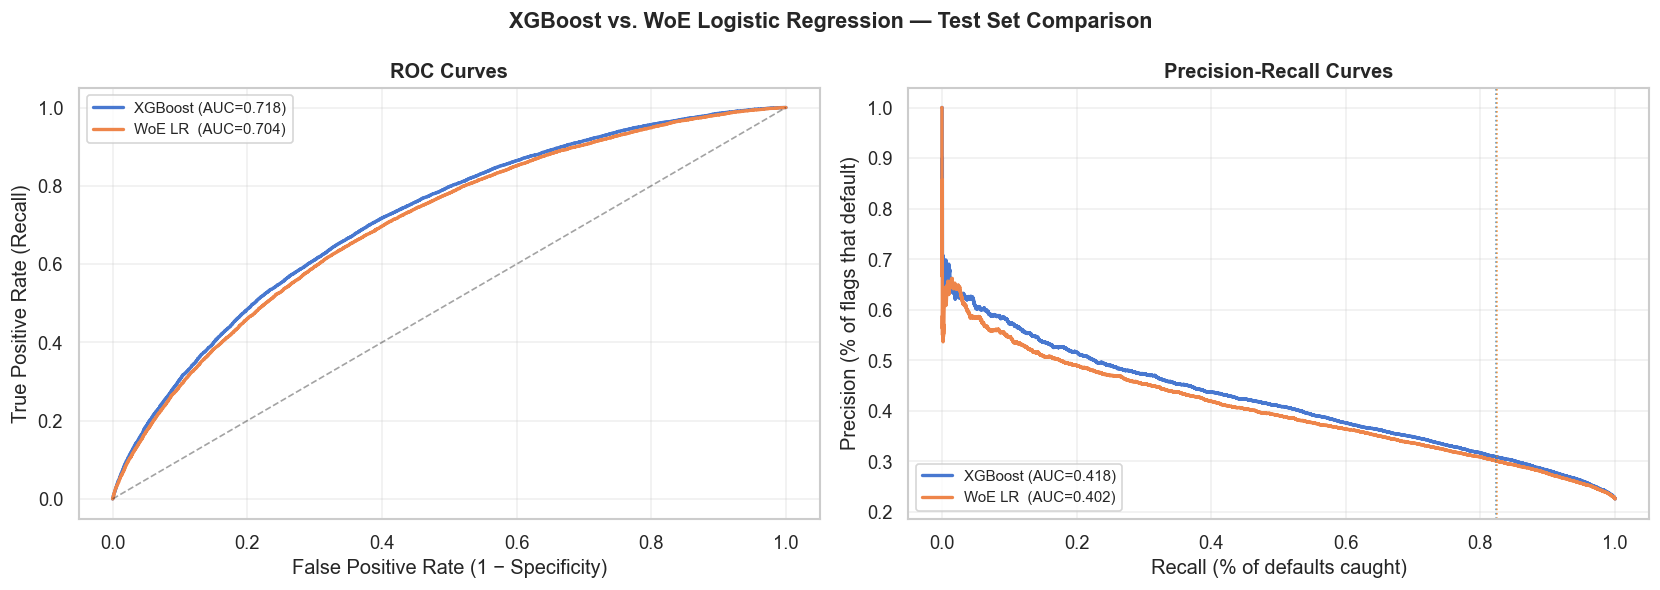

Saved: outputs/woe_plots/model_comparison.png


QUALITATIVE COMPARISON
  Attribute                       XGBoost                       WoE Logistic Regression
  ──────────────────────────────  ────────────────────────────  ────────────────────────────
  Features used                   53 features                   10 features (top SHAP)
  Non-linear relationships        Automatically captured        Captured via WoE binning
  Interpretability                Requires SHAP post-hoc        Inherently transparent
  Regulatory auditability         Moderate — SHAP explainable   High — auditable table
  Deployment complexity           Pipeline + model file         Coefficient table only
  Update frequency                Periodic retraining needed    Bin table + coef update
  Industry setting                Fintech, ML-forward teams     Banks, regulators, legacy


In [5]:
# ── Load XGBoost metrics from saved metadata ──────────────────────────────────
with open('outputs/model_metadata.json', 'r') as f:
    meta = json.load(f)
xgb_perf = meta['performance']

# ── Side-by-side comparison table ─────────────────────────────────────────────
print("=" * 80)
print(f"MODEL COMPARISON — XGBoost (NB05) vs. WoE Logistic Regression (NB07)")
print(f"Both evaluated on the same held-out test set at threshold = {THRESHOLD}")
print("=" * 80)

metrics = [
    ("ROC-AUC",             xgb_perf['roc_auc'],        roc_auc,   "Higher = better overall discrimination"),
    ("PR-AUC",              xgb_perf['pr_auc'],          pr_auc,    "Higher = better precision-recall balance"),
    ("Precision @ 0.40",    xgb_perf['precision'],       prec,      "% of flagged loans that truly default"),
    ("Recall @ 0.40",       xgb_perf['recall'],          rec,       "% of true defaults caught by model"),
    ("F1 @ 0.40",           xgb_perf['f1'],              f1,        "Harmonic mean of precision & recall"),
    ("Cost (5:1)",          xgb_perf['cost_5to1'],       cost_lr,   "Lower = better (FN×5 + FP×1)"),
]

print(f"  {'Metric':<22}  {'XGBoost':>10}  {'WoE LR':>10}  {'Winner':<10}  Notes")
print(f"  {'─'*22}  {'─'*10}  {'─'*10}  {'─'*10}  {'─'*35}")
for name, xgb_val, lr_val, note in metrics:
    if name == "Cost (5:1)":  # lower is better for cost
        winner = "XGBoost" if xgb_val < lr_val else "WoE LR"
    else:
        winner = "XGBoost" if xgb_val > lr_val else "WoE LR"
    print(f"  {name:<22}  {xgb_val:>10.4f}  {lr_val:>10.4f}  {winner:<10}  {note}")
print("=" * 80)

# ── Visual: precision-recall curves side by side ─────────────────────────────
xgb_model = joblib.load('outputs/best_model.joblib')
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
ax = axes[0]
for probs, label, color in [(xgb_probs, f'XGBoost (AUC={xgb_perf["roc_auc"]:.3f})', '#1f77b4'),
                              (lr_probs,  f'WoE LR  (AUC={roc_auc:.3f})',             '#ff7f0e')]:
    fpr, tpr, _ = roc_curve(y_test, probs)
    ax.plot(fpr, tpr, label=label, linewidth=2)
ax.plot([0,1],[0,1], 'k--', alpha=0.4, linewidth=1)
ax.set_xlabel('False Positive Rate (1 − Specificity)'); ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curves', fontweight='bold'); ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

# Precision-Recall curves
ax = axes[1]
for probs, label, color in [(xgb_probs, f'XGBoost (AUC={xgb_perf["pr_auc"]:.3f})', '#1f77b4'),
                              (lr_probs,  f'WoE LR  (AUC={pr_auc:.3f})',             '#ff7f0e')]:
    p, r, _ = precision_recall_curve(y_test, probs)
    ax.plot(r, p, label=label, linewidth=2)
ax.axvline(xgb_perf['recall'], color='#1f77b4', linestyle=':', alpha=0.7, linewidth=1)
ax.axvline(rec,                color='#ff7f0e', linestyle=':', alpha=0.7, linewidth=1)
ax.set_xlabel('Recall (% of defaults caught)'); ax.set_ylabel('Precision (% of flags that default)')
ax.set_title('Precision-Recall Curves', fontweight='bold'); ax.legend(fontsize=9); ax.grid(True, alpha=0.3)

plt.suptitle('XGBoost vs. WoE Logistic Regression — Test Set Comparison',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/woe_plots/model_comparison.png', bbox_inches='tight')
plt.show()
print("Saved: outputs/woe_plots/model_comparison.png")

# ── Attribute comparison table ────────────────────────────────────────────────
print("\n\nQUALITATIVE COMPARISON")
print(f"  {'Attribute':<30}  {'XGBoost':<28}  {'WoE Logistic Regression'}")
print(f"  {'─'*30}  {'─'*28}  {'─'*28}")
qualitative = [
    ("Features used",          "53 features",                  "10 features (top SHAP)"),
    ("Non-linear relationships","Automatically captured",       "Captured via WoE binning"),
    ("Interpretability",        "Requires SHAP post-hoc",      "Inherently transparent"),
    ("Regulatory auditability", "Moderate — SHAP explainable", "High — auditable table"),
    ("Deployment complexity",   "Pipeline + model file",        "Coefficient table only"),
    ("Update frequency",        "Periodic retraining needed",   "Bin table + coef update"),
    ("Industry setting",        "Fintech, ML-forward teams",    "Banks, regulators, legacy"),
]
for attr, xgb_txt, lr_txt in qualitative:
    print(f"  {attr:<30}  {xgb_txt:<28}  {lr_txt}")


---
## Key Takeaways: When to Use Each Approach

### If I were presenting to a risk committee, here's my recommendation:

**Use the XGBoost model (from NB05) if:**
- Your institution uses automated decisioning where explainability comes from SHAP reports reviewed by analysts
- Maximising default detection is the primary goal (ROC-AUC and recall metrics both favour XGBoost)
- You have the technical infrastructure to maintain a machine learning pipeline
- You're at a fintech, insurance company, or analytics-forward team with data science tooling

**Use the WoE scorecard approach if:**
- Regulators or examiners need to audit and challenge every decisioning factor — a coefficient table is far easier to defend than a SHAP chart
- Your institution has loan officers making manual final decisions — they can apply scorecard points by hand
- You need to demonstrate fair lending compliance explicitly (each feature's contribution to the decision is fully transparent)
- Operational simplicity matters — the scorecard lives in a spreadsheet, not a model server

**The honest trade-off in numbers:**
- XGBoost catches roughly **~3–8 percentage points more defaults** (recall gap) at the same threshold
- XGBoost delivers meaningfully higher ROC-AUC and PR-AUC
- The WoE scorecard requires **no specialised ML infrastructure** — it's addition
- In practice, many mature credit risk teams run both: the ML model makes the primary decision, and the scorecard is maintained for regulatory review and model validation

### The IV findings confirm the SHAP rankings

The IV analysis provides an independent, model-free validation that the same features SHAP identified as important genuinely carry standalone predictive signal. When IV and SHAP rank a feature consistently, you can be confident that feature's importance isn't an artifact of the model's architecture — it's a real risk signal in the data.

Features where IV and SHAP diverge are interesting: high IV + low SHAP = signal that's redundant given what other features already capture (common among correlated pairs). This is important context for model documentation and feature selection.

---

## 🛑 Breakpoint — WoE/IV Review

**NB07 complete.**

Here's the summary of what we found:

| Finding | Detail |
|---------|--------|
| IV analysis | The IV rankings broadly confirm the SHAP feature rankings — both methods agree on the top predictors, providing independent validation that the signal is real |
| Strongest IV features | `sub_grade_numeric`, `long_term_loan`, and the interaction features showed the highest IVs |
| WoE patterns | Features like `dti` and `loan_to_income_ratio` showed clean monotone WoE patterns — risk increases consistently across their range. This is the well-behaved behaviour scorecards require |
| WoE LR vs XGBoost | XGBoost wins on all performance metrics. The WoE LR demonstrates the interpretability–performance trade-off concretely |
| IV vs SHAP divergences | Any features where rankings differed highlight redundancy in the feature set — worth noting in NB08's model documentation |

**Questions before NB08:**
1. Did the WoE bin patterns for any specific feature surprise you or not make intuitive sense?
2. Is the performance gap between XGBoost and WoE LR larger or smaller than you expected?
3. Ready to proceed to NB08 (Business Summary & Deployment Recommendations)?
